In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from kret_studies import *
from kret_studies.notebook_imports import *

In [3]:
features = ["Concentration", "Age", "Weight"]
y_col = ["Clearance"]
names_ordered = features + y_col
df = pd.read_csv("HW3.txt", sep=r"\s+", names=y_col + features, header=0)

In [4]:
df = df[names_ordered]

In [5]:
df.head(3)

,Concentration,Age,Weight,Clearance
0,0.71,38.0,71.0,132.0
1,1.48,78.0,69.0,53.0
2,2.21,69.0,85.0,50.0


### (a) Obtain the scatterplot matrix. What do the scatter plots suggest about the nature or the functional relationship between Y and the predictor variables?

In [6]:
fig, ax = uks_mpl.subplots(3)
uks_mpl.style_axes(fig, ax)

/Users/Akseldkw/coding/kretsinger/kret_studies/matplotlibutils.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


In [7]:
for i, col in enumerate(features):
    ax[i].scatter(df[col], df[y_col])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel(y_col[0])
    ax[i].set_title(f"{col} vs {y_col[0]}")

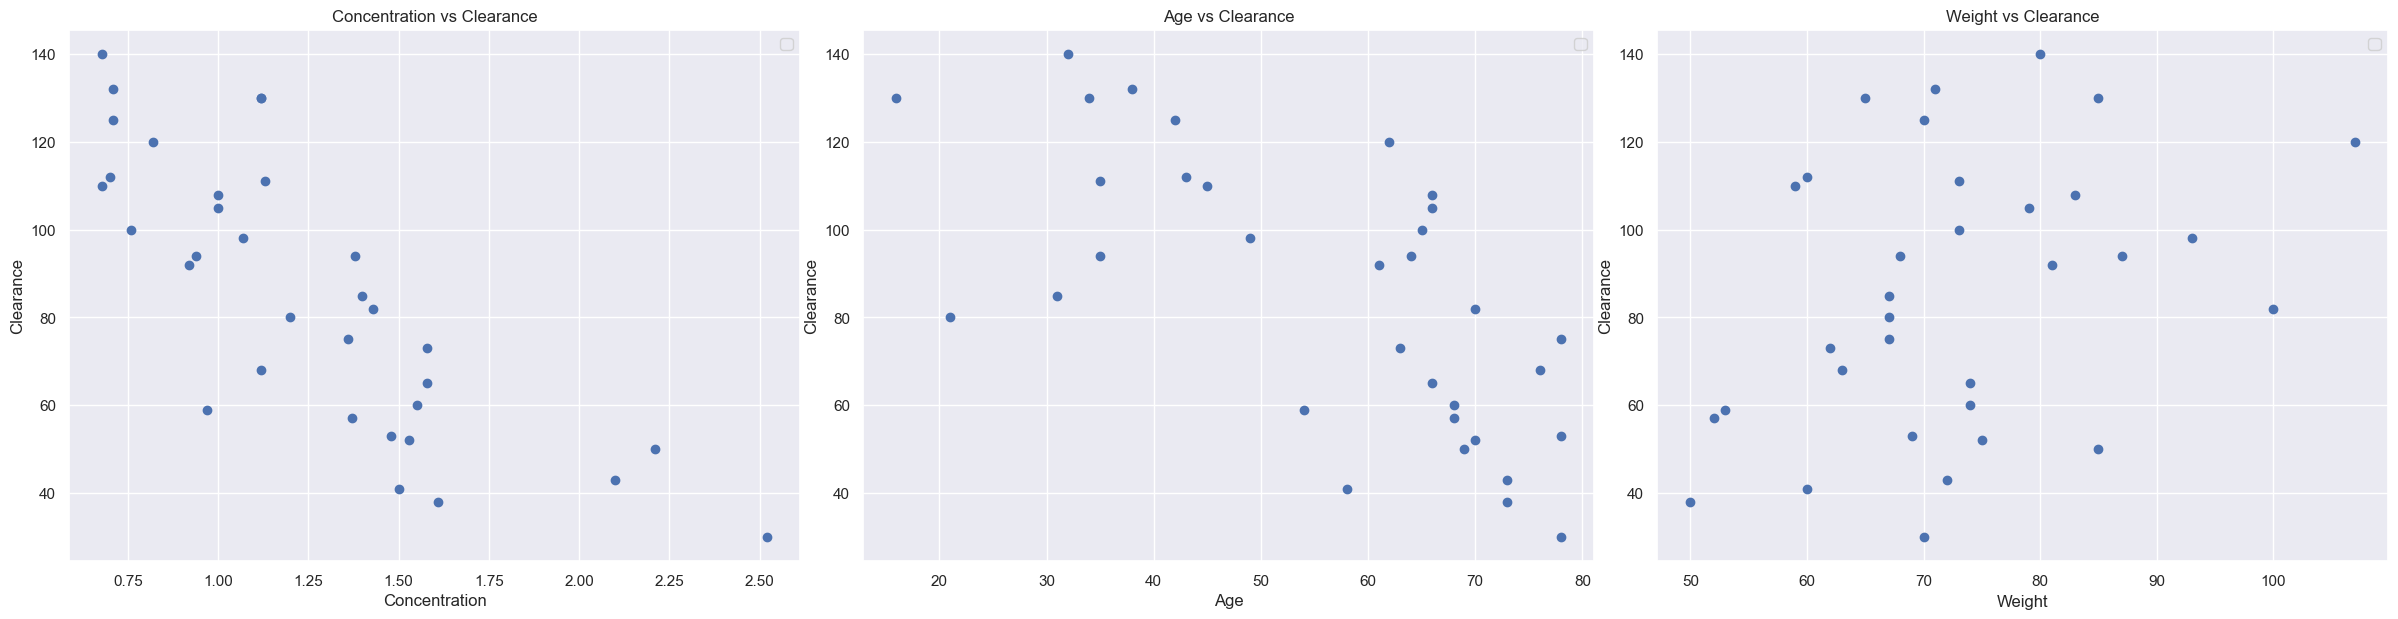

In [8]:
fig

I think that the concentration <--> clerance scatterplot has the tightest grouping. It's worth noting that the relationship doesn't appear to be linear (as in x^1 linear). I would eyeball that a simple a * x^-1 + b approximation, at least within the x & y bounds visible, would have a decent fit. 

Age and clearance appear to be less tightly related. My rough simplification of the relationship would be that age is non-predictive up until age 50, at which point it clearly trends downward. Maybe a -x^2 relationship would explain it decently 

Weight vs clearance is clearly positive (and probably linear), but with very high variance

### (b) Obtain the correlation matrix of the X variables Are any serious multicollinearity problems evident?

In [9]:
corr = df[features].corr()

In [10]:
corr2 = corr.copy(deep=True)
corr2.iloc[0, 1] = -0.87

In [11]:
corr

,Concentration,Age,Weight
Concentration,1.000000,0.467732,-0.088983
Age,0.467732,1.000000,0.068481
Weight,-0.088983,0.068481,1.000000


In [12]:
corr2

,Concentration,Age,Weight
Concentration,1.000000,-0.870000,-0.088983
Age,0.467732,1.000000,0.068481
Weight,-0.088983,0.068481,1.000000


In [13]:
fig, ax = uks_mpl.subplots(1)

In [14]:
_ = uks_mpl.heatmap_df(corr2, ax=ax)

'df_min=-0.87 df_max=1.0, abs_max=1.0'

{'vmin': -1.0,
 'vmax': 1.0,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'fmt': '.1f'}

{'annot': True,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'linewidths': 0.1,
 'cbar': True,
 'vmin': -1.0,
 'vmax': 1.0,
 'fmt': '.1f',
 'ax': <Axes: >}

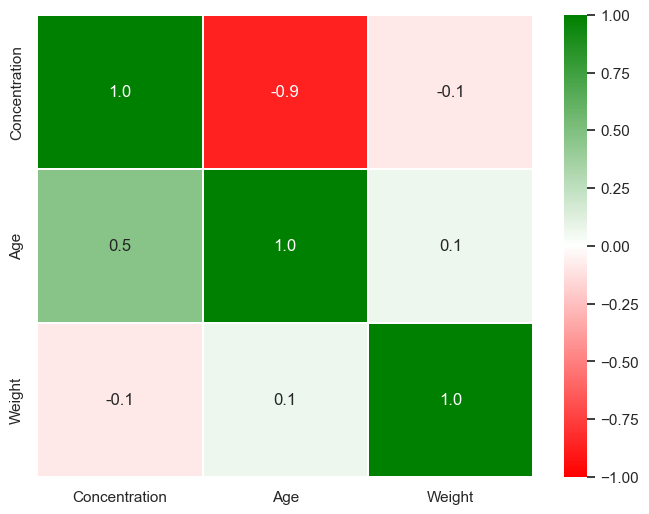

In [15]:
fig

In [16]:
my_red_white_green_cmap = uks_mpl.red_green_centered

In [17]:
data_balanced_diverging = np.random.rand(10, 10) * 100 - 15  # Data ranging e.g. from -5 to 95
df_test = pd.DataFrame(data_balanced_diverging)

In [18]:
df_test

,0,1,2,3,4,5,6,7,8,9
0,6.941998,67.092402,36.820928,25.455793,73.707018,51.182959,43.149027,-13.458921,60.379177,32.317230
1,53.258686,49.658017,28.963394,54.271097,68.576544,84.773233,73.322478,74.974329,49.594544,2.967459
2,22.846687,13.879064,70.791678,39.550115,66.112899,26.548034,44.296597,28.321674,12.145756,39.441340
3,11.013223,-9.853619,15.906459,4.895514,-12.832123,47.026263,-7.454579,3.608429,-1.170764,50.040547
4,34.191920,15.738167,54.454329,9.568444,46.571467,64.028650,-12.778367,66.884641,25.197405,83.813238
5,31.724881,52.546409,82.229700,66.461783,82.011856,-12.808547,40.306730,76.023962,-6.268873,14.168854
6,-9.763961,8.416462,75.559563,6.214010,74.015752,47.639117,9.791249,62.732319,-5.428982,0.307090
7,66.978165,16.071043,54.669335,33.875099,61.444481,40.337714,8.226223,15.818431,78.803382,26.605735
8,-1.974714,23.352264,13.251740,79.583792,62.537541,46.776079,54.266393,57.639547,65.747044,55.478552
9,67.685393,67.141639,66.558416,67.165403,54.902885,43.346176,44.272362,63.126445,16.985931,8.668362


'df_min=-13.45892074176077 df_max=84.7732334884815, abs_max=84.7732334884815'

{'vmin': -84.7732334884815,
 'vmax': 84.7732334884815,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'fmt': '.0f'}

{'annot': True,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'linewidths': 0.1,
 'cbar': True,
 'vmin': -84.7732334884815,
 'vmax': 84.7732334884815,
 'fmt': '.0f'}

<Axes: >

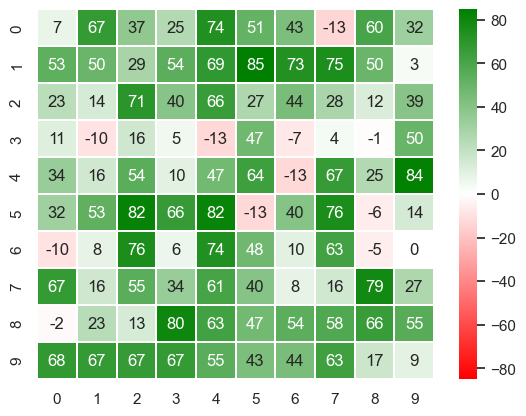

In [19]:
uks_mpl.heatmap_df(df_test)

<Axes: >

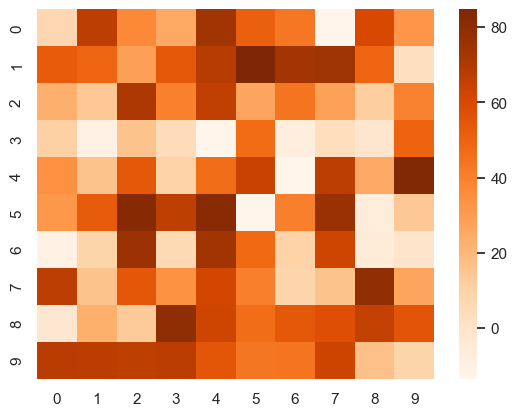

In [20]:
sns.heatmap(df_test, cmap="Oranges")

In [21]:
data_negative = -np.random.rand(10, 10) * 100 - 1  # Data ranging e.g. from -5 to 95
df_neg = pd.DataFrame(data_negative)

<Axes: >

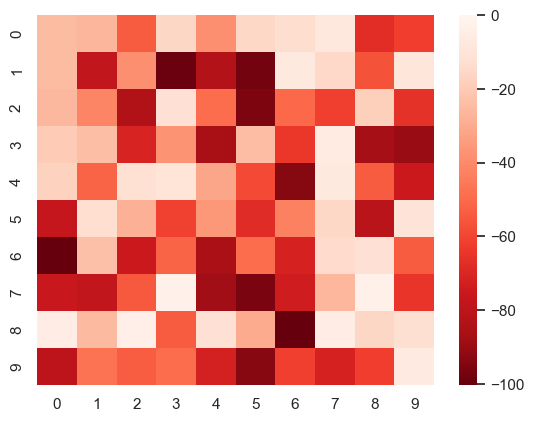

In [22]:
sns.heatmap(
    data_negative,
    cmap="Reds_r",  # Reversed Reds: Dark red for values near min, lighter red towards 0
    vmin=data_negative.min(),  # Maps min to 0.0 of colormap
    vmax=0.0,
)

'df_min=-100.25759159993362 df_max=-2.5678178849899416, abs_max=100.25759159993362'

{'vmin': -100.25759159993362,
 'vmax': 0,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x143bff4a0>,
 'fmt': '.0f'}

{'annot': True,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x143bff4a0>,
 'linewidths': 0.1,
 'cbar': True,
 'vmin': -100.25759159993362,
 'vmax': 0,
 'fmt': '.0f'}

<Axes: >

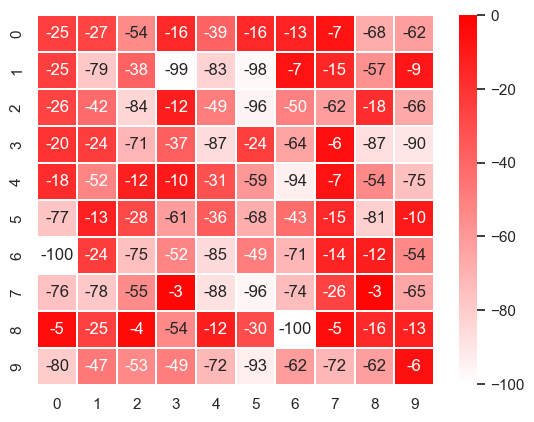

In [23]:
uks_mpl.heatmap_df(df_neg)

In [ ]:
data_pos = -np.random.rand(10, 10) * 100 + 1  # Data ranging e.g. from -5 to 95
df_pos = pd.DataFrame(data_pos)

'df_min=-98.90975337516667 df_max=0.8756413908995833, abs_max=98.90975337516667'

{'vmin': -98.90975337516667,
 'vmax': 98.90975337516667,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'fmt': '.0f'}

{'annot': True,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1455fcd70>,
 'linewidths': 0.1,
 'cbar': True,
 'vmin': -98.90975337516667,
 'vmax': 98.90975337516667,
 'fmt': '.0f'}

<Axes: >

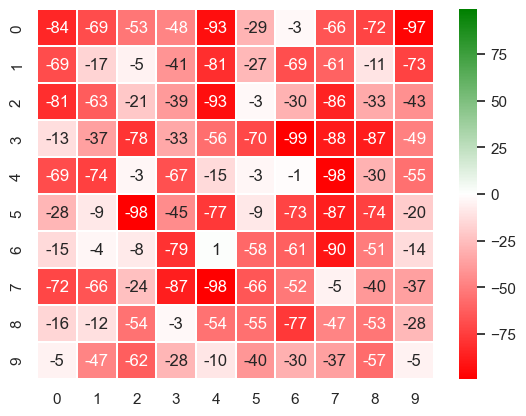

In [36]:
uks_mpl.heatmap_df(df_pos)